# Data-driven attribution (DDA) experiments (local)

## Imports and Dependencies

- `tabulate`
- `tqdm`
- `smart_open[s3]`
- `s3fs`

In [12]:
pip install tabulate tqdm smart_open matplotlib s3fs

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Run the following either here or on the terminal [with "sudo" if on the terminal]
# !/emr/notebook-env/bin/pip install tabulate tqdm smart_open[s3] matplotlib s3fs

In [15]:
import os
import pandas as pd
from tqdm.notebook import tqdm
import json
import pickle
from collections import Counter
from tabulate import tabulate
import subprocess
from smart_open import open

## Function definitions

In [16]:
# Parses each line of the events file.
# line: One line of the events file (one user event string)
# resolve_properties: Whether to append an 'epr'/'upr' to properties or not.
# ignore_properties: Whether to get rid of all properties at all or not.
# keep: Either have this as None, or give a list of all keys that you need to retain.
# keep_events: Either give None, or give a whitelist of events to keep.
#              If there's an event matched to be ignored, the function returns None.
def parse_line(line,
               resolve_properties=False,
               ignore_properties=False,
               keep=None,
               keep_events=None):
    if resolve_properties and ignore_properties:
        raise Exception(
            "Cannot resolve and ignore properties at the same time.")
    line = json.loads(line.strip())
    if keep_events is not None:
        if line['en'] not in keep_events:
            return None
    if ignore_properties:
        del line['epr'], line['upr']
    if resolve_properties:
        line.update({f'epr_{k}': v for k, v in line['epr'].items()})
        line.update({f'upr_{k}': v for k, v in line['upr'].items()})
        del line['epr'], line['upr']
    if keep is not None:
        line = {k: line[k] for k in keep if k in line}
    return line


# Computes division in a more smart fashion.
def smart_divide(a, b):
    if b == 0:
        if a == 0:
            return 0
        return float('Inf')
    return 1.0 * a / b


# Gives conversion summary.
# Gets the summary of the first conversion for every user. Either the user doesn't convert
# at all (i.e., if resolved_ids is None) -- 'not_converted'.
# Or the user converts in Session 0 (a dummy session for cases where there's no session) -- 'converted_wo_session',
# or the user converts for more than one times -- 'converted_in_>=1_session'.
def get_summary(resolved_ids):
    if resolved_ids is None:
        return 'not_converted'
    if resolved_ids == [0]:
        return 'converted_wo_session'
    return 'converted_in_>=1_session'


# Caches and retrieves from S3, the first dataframe "df" (one-touch-per-row)
# that we generate from the raw events.txt file.
# This uses the parse_line function and creates a dataframe out of it.
def get_df(s3_events_file_path, force_fresh=False):
    try:
        if force_fresh:
            raise ImportError
        df = pd.read_csv(s3_events_file_path+'.csv', index_col=0)
    except Exception:
        meta_cols = ['uid', 'en', 'et']
        att_cols = ['epr_$campaign', 'epr_$campaign_id', 'epr_$channel']
        keep_cols = meta_cols + att_cols
        with open(s3_events_file_path, 'r') as f:
            lines = []
            for index, line in tqdm(enumerate(f), total=nlines):
                line = parse_line(line,
                                  resolve_properties=True,
                                  ignore_properties=False,
                                  keep=keep_cols,
                                  keep_events={tgt_event, '$session'})
                if line is None:
                    continue
                lines.append(line)
        df = pd.DataFrame(lines).fillna('$none')
        df['et'] = pd.to_datetime(df['et'], unit='s')
        df.to_csv(s3_events_file_path+'.csv')
    return df

# Caches and retrieves from S3, the grouped-aggregated dataframe "user-df" (one-user-per-row)
# that we generate from df.
def get_user_df(s3_events_file_path, df=None, force_fresh=False):
    user_df_path = s3_events_file_path+'.user'
    try:
        if force_fresh:
            raise ImportError
        user_df = pickle.load(open(user_df_path+'.pkl', 'rb'))
    except Exception:
        if df is None:
            df = get_df(s3_events_file_path)
        user_df = df.fillna('$none').groupby('uid').agg(list)
        pickle.dump(user_df, open(user_df_path+'.pkl', 'wb'))
    return user_df

# Takes in user-df (one-user-per-row) information and returns
# conversion and non-conversion based stats, while retaining or
# losing the sequence information.
def get_final_data(user_df, touch_mode, sequence=True):
    final_df = user_df[user_df['n_uniq_ch'] >= 1].apply(lambda x: ([x[touch_mode][i] for i in x['resolved_ids'] if x[touch_mode][i] != '$none']), axis=1)
    final_df = pd.DataFrame({'seq_str': final_df.apply(' -> '.join), 'seq': final_df.apply(tuple if sequence else frozenset)})
    final_df = final_df[final_df['seq'].apply(lambda x: len(x) > 0)]
    
    final_df0 = user_df[user_df['summary'] == 'not_converted'].apply(lambda x: ([y for y in x[touch_mode] if y != '$none']), axis=1)
    final_df0 = pd.DataFrame({'seq_str': final_df0.apply(' -> '.join), 'seq': final_df0.apply(tuple if sequence else frozenset)})
    final_df0 = final_df0[final_df0['seq'].apply(lambda x: len(x) > 0)]
    # print(tabulate(final_df[['seq_str']], headers='keys', tablefmt='psql'))
    return final_df, final_df0

# Processes conversion and non-conversion based stats while
# retaining or losing the sequence information.
def get_conversion_info(conv_df, nconv_df, sequence=True):
    col_name = 'seq' if sequence else 'set' 
    if not sequence:
        conv_df[col_name] = conv_df['seq'].apply(frozenset)
        nconv_df[col_name] = nconv_df['seq'].apply(frozenset)

    conv = conv_df.groupby(col_name).agg(len).to_dict()['seq_str']
    nconv = nconv_df.groupby(col_name).agg(len).to_dict()['seq_str']

    conv_dict = {k: (conv[k], nconv.get(k, 0), smart_divide(conv[k], conv[k]+nconv.get(k, 0))) for k in conv}

    return conv_dict

# Computes shapley values from conversion information.
def find_shapley_values(conv_dict, tgt_mode):
    synergy_dict = {k: v[0 if tgt_mode is 'c' else -1] for k, v in conv_dict.items()}
    shapley = defaultdict(float)
    for coal, syn in synergy_dict.items():
        size = len(coal)
        for item in coal:
            shapley[item] += syn/size
    scores = shapley
    return scores

# Computes linear and weighted attribution from conversion information.
# mode=const: average attribution
# mode=lini: linear-increasing: lower weight to first-touch and higher to last-touch
# mode=lind: linear-decreasing: higher weight to first-touch and lower to last-touch
def find_avg_att(conv_dict, tgt_mode, mode='const'):
    convs = defaultdict(float)
    nconvs = defaultdict(float)
    for k, v in conv_dict.items():
        size = len(k)
        if mode == 'const':
            wts = np.ones((size,))
        elif mode == 'lini':
            wts = np.linspace(0, 1, size+1)[1:]
        elif mode == 'lind':
            wts = np.linspace(1, 0, size+1)[:-1]
        wts = wts / wts.sum()
        for i, key in enumerate(k):
            convs[key] += v[0]/wts[i]
            nconvs[key] += v[1]/wts[i]
    if tgt_mode == 'c':
        return dict(convs)
    if tgt_mode == 'cr':
        scores = {k:smart_divide(convs[k], convs[k]+nconvs[k]) for k in convs}
        return scores

# Computes single-touch, both first-touch and last-touch attributions
def find_single_touch(conv_dict, tgt_mode, mode):
    convs = defaultdict(float)
    nconvs = defaultdict(float)
    for k, v in conv_dict.items():
        convs[k[0 if mode == 'first' else -1]] += v[0]
        nconvs[k[0 if mode == 'first' else -1]] += v[1]
    if tgt_mode == 'c':
        return dict(convs)
    if tgt_mode == 'cr':
        scores = {k:smart_divide(convs[k], convs[k]+nconvs[k]) for k in convs}
        return scores
    
# Find all attribution scores given conversion and non-conversion info
def find_att_scores(conv_df, nconv_df, att_mode, tgt_mode):
    if att_mode.startswith('shap'): # Shapley
        conv_dict = get_conversion_info(conv_df, nconv_df, sequence=False)
        return find_shapley_values(conv_dict, tgt_mode)
    elif att_mode.startswith('ft'): # First touch
        conv_dict = get_conversion_info(conv_df, nconv_df, sequence=True)
        return find_single_touch(conv_dict, tgt_mode, 'first')
    elif att_mode.startswith('lt'): # First touch
        conv_dict = get_conversion_info(conv_df, nconv_df, sequence=True)
        return find_single_touch(conv_dict, tgt_mode, 'last')
    elif att_mode.startswith('avg'):
        conv_dict = get_conversion_info(conv_df, nconv_df, sequence=True)
        return find_avg_att(conv_dict, tgt_mode, 'const')
    elif att_mode.startswith('lini'):
        conv_dict = get_conversion_info(conv_df, nconv_df, sequence=True)
        return find_avg_att(conv_dict, tgt_mode, 'lini')
    elif att_mode.startswith('lind'):
        conv_dict = get_conversion_info(conv_df, nconv_df, sequence=True)
        return find_avg_att(conv_dict, tgt_mode, 'lind')

## Set up paths from S3
- Change `project_id` to the respective client
- Change `st_date` to the desired period
- Change `mode` to eithe `m` or `w` for monthly or weekly
- Change `tgt_event` to change the target/conversion-event information

In [28]:
cloud_mode = 'colab' # Can be 'local', 'colab', 'aws', or 'gcp'

project_id = '1' # A sample.
# project_id = '399' # ChargeBee
# project_id = '559' # AdPushup

mode = 'm'
st_date = '20210901'

nlines = {'1': {'20210901': 5000},
          '559': {'20210901': 490204},
          '399': {'20210901': 1409686}}[project_id][st_date]

tgt_event = {'1': "www.chargebee.com/pricing",
             '559': '$hubspot_contact_created',
             '399': '$hubspot_contact_created'}[project_id]
events_file_name = 'events.txt'

if cloud_mode == 's3':
    s3_bucket = 'data-driven-attribution'
    cloud_storage_path = os.path.join('s3://', s3_bucket, 'data', 'cloud_storage')
elif cloud_mode == 'local':
    local_cloud_home = '/usr/local/var/factors'
    cloud_storage_path = os.path.join(local_cloud_home, 'cloud_storage')
elif cloud_mode == 'colab':
    local_cloud_home = '/content/drive/MyDrive'
    cloud_storage_path = os.path.join(local_cloud_home, 'cloud_storage')
events_file_path = os.path.join(cloud_storage_path, 'projects', project_id, 'events', mode, st_date, events_file_name)


In [29]:
events_file_path

'/content/drive/MyDrive/cloud_storage/projects/1/events/m/20210901/events.txt'

In [30]:
# Checks if a sequence of events ended up in "conversion target",
# and trims it after the *first* target occurrence. If target not
# achieved, returns None.
# This function uses a global variable, tgt_event as the second argument tgt_event.
def get_resolved_event_ids(list_of_events, tgt_event=tgt_event):
    resolved_id_list = []
    tgt_achieved_flag = False
    for i, e in enumerate(list_of_events):
        resolved_id_list.append(i)
        if e == tgt_event:
            tgt_achieved_flag = True
            break
    return resolved_id_list if tgt_achieved_flag else None


## Read or process event-level data

In [37]:
df = get_df(events_file_path) # Read events file line by line, and retain only relevant events and properties.
print('rows, columns: ', df.shape)
if 'epr_$channel' not in df.columns:
    df['epr_$channel'] = df['epr_$campaign']
df.head()

rows, columns:  (2078, 4)


,uid,en,et,epr_$campaign,epr_$channel
0,0000d256-25bd-46c3-a6e7-d2c0420afc0a,$session,2020-09-28 06:26:45,RLSA_Global,RLSA_Global
1,0006ac0c-d42a-40e6-b093-4572c17c7427,$session,2020-10-01 12:49:34,$none,$none
2,0006ac0c-d42a-40e6-b093-4572c17c7427,$session,2020-10-02 09:51:57,$none,$none
3,0009daf2-c2b0-4347-ac2b-fbce08129980,$session,2020-09-28 00:38:38,Stripe_NA_Exact,Stripe_NA_Exact
4,0009daf2-c2b0-4347-ac2b-fbce08129980,$session,2020-09-28 00:38:38,Stripe_NA_Exact,Stripe_NA_Exact


In [38]:
# Total conversion ratio.
u = df['uid'].nunique()
c = df[df['en'] == tgt_event]['uid'].nunique()
cr = round(smart_divide(c, u)*100, 4)
print('unique users:', u, 'converts:', c, 'ratio:', cr)

unique users: 1289 converts: 127 ratio: 9.8526


In [39]:
ncamp = df['epr_$campaign'].nunique()
nch = df['epr_$channel'].nunique()
print(ncamp, 'campaigns,', nch, 'channels')

109 campaigns, 109 channels


## User-level group-aggregated data

In [41]:
user_df = get_user_df(events_file_path, df) # Aggregate users on the 'uid' column, and collect the list of events, properties, etc.

In [42]:
print('rows, columns:', user_df.shape)

rows, columns: (1289, 4)


### Conversion stats

In [43]:
user_df['resolved_ids'] = user_df['en'].apply(lambda x: get_resolved_event_ids(x)) # Resolve conversion (only consider the first conversion as the convert event)
user_df['summary'] = user_df['resolved_ids'].apply(lambda x: get_summary(x)) # Divide users into 3 classes.
print('***User distribution based on conversion***')
user_df['summary'].value_counts()

***User distribution based on conversion***


not_converted               1162
converted_in_>=1_session     127
Name: summary, dtype: int64

### Campaign-level stats
This part shows the number of **unique campaign-touchpoints** each **converted user** goes through. What is being shown in the table is the number of unique campaign touch-points (1st column), and number of users with that property (2nd column).

In [45]:
# user_df['n_uniq_tp_id'] = user_df.apply(lambda x: None if x['summary'] != 'converted_in_>=1_session' else len(set([i for i in [x['epr_$campaign_id'][j] for j in x['resolved_ids']] if i != '$none'])), axis=1)
user_df['n_uniq_tp'] = user_df.apply(lambda x: None if x['summary'] != 'converted_in_>=1_session' else len(set([i for i in [x['epr_$campaign'][j] for j in x['resolved_ids']] if i != '$none'])), axis=1)
user_df['n_uniq_ch'] = user_df.apply(lambda x: None if x['summary'] != 'converted_in_>=1_session' else len(set([i for i in [x['epr_$channel'][j] for j in x['resolved_ids']] if i != '$none'])), axis=1)
print('***Distribution of number of unique non-$none campaigns***')
user_df[user_df['summary'] == 'converted_in_>=1_session']['n_uniq_tp'].value_counts()

***Distribution of number of unique non-$none campaigns***


0.0    83
1.0    44
Name: n_uniq_tp, dtype: int64

### Channel-level stats
This part shows the number of **unique channel-touchpoints** each **converted user** goes through. What is being shown in the table is the number of unique channel touch-points (1st column), and number of users with that property (2nd column)

In [46]:
print('***Distribution of number of unique non-$none channels***')
user_df[user_df['summary'] == 'converted_in_>=1_session']['n_uniq_ch'].value_counts()

***Distribution of number of unique non-$none channels***


0.0    83
1.0    44
Name: n_uniq_ch, dtype: int64

## Touchpoint conversion stats

Using information from "channel" or "campaign" (a parameter to be set), find conversion stats w.r.t. 'channel' or 'campaign' sequences.

In [47]:
# touch_mode = 'epr_$campaign'
touch_mode = 'epr_$channel'
conv_df, nconv_df = get_final_data(user_df, touch_mode, sequence=True)

### Sequence and multiplicity retained

In [48]:
def rep_format(x):
    items = []
    prev_c = x[0]
    count = 1
    for i, c in enumerate(x[1:]):
        if c == prev_c:
            count += 1
        else:
            item = f'{prev_c}({count})' if count > 1 else prev_c
            items.append(item)
            count = 1
        prev_c = c
    item = f'{prev_c}({count})' if count > 1 else prev_c
    items.append(item)
    return tuple(items)

In [50]:
conv_dict = get_conversion_info(conv_df, nconv_df, sequence=True)
conv_dict = {rep_format(k): v for k, v in conv_dict.items()}
conv_dict = {' -> '.join(k): v for k, v in conv_dict.items()}
conv_dict_df = pd.DataFrame(conv_dict).T
conv_dict_df.columns = ['conv', 'non-conv', 'conv-ratio']
conv_dict_df['cr_perc'] = conv_dict_df['conv-ratio'].apply(lambda x: f'{"{:2.2f}".format(round(x*100, 2))}%')
conv_dict_df = conv_dict_df.sort_values('conv-ratio', ascending=False)
conv_dict_df.to_csv(events_file_path+f'.{touch_mode}.conv-seq.csv')
conv_dict_df

,conv,non-conv,conv-ratio,cr_perc
BlueSnap_EU_New(2),1.0,0.0,1.000000,100.00%
Chargify_NA_New,1.0,0.0,1.000000,100.00%
billing-invoicing,1.0,0.0,1.000000,100.00%
Subscription_AU_New(2),1.0,0.0,1.000000,100.00%
Stripe_Billing_EU_New(2),1.0,0.0,1.000000,100.00%
SaaS_NA_New(3),1.0,0.0,1.000000,100.00%
Contract_QTC_EU_Exp,1.0,0.0,1.000000,100.00%
Recurring_EU_Exact,1.0,0.0,1.000000,100.00%
subscription(2),1.0,0.0,1.000000,100.00%
Branded_EU_New(3),1.0,0.0,1.000000,100.00%


In [51]:
print('\n'.join(([str(round(conv_dict[k][-1]*100, 2))+ '%'+ '\t'+ k for k in sorted(conv_dict, key=lambda x: -conv_dict[x][-1])])))

100.0%	BlueSnap_EU_New(2)
100.0%	Branded_EU_New(3)
100.0%	Branded_NA_Broad(2)
100.0%	Chargify_NA_New
100.0%	Contract_QTC_EU_Exp
100.0%	Recurring_EU_Exact
100.0%	SaaS_NA_New(3)
100.0%	Stripe_Billing_EU_New(2)
100.0%	Subscription_AU_New(2)
100.0%	billing-invoicing
100.0%	subscription(2)
66.67%	Stripe_EU_Exact(2)
66.67%	Stripe_NA_Exact(2)
60.0%	recurring-billing
50.0%	Branded_AU_New
50.0%	Branded_EU_New(2)
50.0%	Branded_EU_New(4)
50.0%	Branded_NA_Broad
50.0%	LEADERSHIP_BOFU
50.0%	Moneris_NA_New
50.0%	Quickbooks_NA_New
50.0%	SaaS_APAC_New
50.0%	SaaS_NA_Exact
33.33%	Invoicing_EU_New
33.33%	Paddle_EU_New(2)
33.33%	Recurring_NA_Exp
33.33%	Subscription_EU_Exact
33.33%	subscription
30.0%	Subscription_EU_New
28.57%	Core_RLSA_Global
25.0%	Recurring_NA_New
13.33%	Stripe_EU_New
11.11%	Branded_NA_Exp
11.11%	Subscription_NA_Exact
7.14%	Branded_EU_New


### Both sequence and multiplicity ignored (only set retained)

In [53]:
conv_dict = get_conversion_info(conv_df, nconv_df, sequence=False)
conv_dict = {', '.join(sorted(k)): v for k, v in conv_dict.items()}
conv_dict_df = pd.DataFrame(conv_dict).T
conv_dict_df.columns = ['conv', 'non-conv', 'conv-ratio']
conv_dict_df['cr_perc'] = conv_dict_df['conv-ratio'].apply(lambda x: f'{"{:2.2f}".format(round(x*100, 2))}%')
conv_dict_df = conv_dict_df.sort_values('conv-ratio', ascending=False)
conv_dict_df.to_csv(events_file_path+f'.{touch_mode}.conv-set.csv')
conv_dict_df

,conv,non-conv,conv-ratio,cr_perc
BlueSnap_EU_New,1.0,0.0,1.000000,100.00%
Contract_QTC_EU_Exp,1.0,0.0,1.000000,100.00%
Recurring_EU_Exact,1.0,0.0,1.000000,100.00%
Stripe_Billing_EU_New,1.0,0.0,1.000000,100.00%
Branded_NA_Broad,2.0,1.0,0.666667,66.67%
recurring-billing,3.0,2.0,0.600000,60.00%
Quickbooks_NA_New,1.0,1.0,0.500000,50.00%
Subscription_AU_New,1.0,1.0,0.500000,50.00%
billing-invoicing,1.0,1.0,0.500000,50.00%
subscription,2.0,2.0,0.500000,50.00%


In [54]:
print('\n'.join(([str(round(conv_dict[k][-1]*100, 2))+ '%'+ '\t'+ k for k in sorted(conv_dict, key=lambda x: -conv_dict[x][-1])])))

100.0%	Stripe_Billing_EU_New
100.0%	Contract_QTC_EU_Exp
100.0%	Recurring_EU_Exact
100.0%	BlueSnap_EU_New
66.67%	Branded_NA_Broad
60.0%	recurring-billing
50.0%	LEADERSHIP_BOFU
50.0%	Subscription_AU_New
50.0%	Quickbooks_NA_New
50.0%	Chargify_NA_New
50.0%	Moneris_NA_New
50.0%	subscription
50.0%	billing-invoicing
33.33%	Stripe_NA_Exact
33.33%	Invoicing_EU_New
33.33%	SaaS_APAC_New
33.33%	Recurring_NA_Exp
33.33%	Subscription_EU_Exact
33.33%	Branded_AU_New
33.33%	SaaS_NA_Exact
30.0%	Subscription_EU_New
28.57%	Stripe_EU_Exact
25.0%	Recurring_NA_New
25.0%	Core_RLSA_Global
20.0%	SaaS_NA_New
20.0%	Branded_EU_New
12.5%	Stripe_EU_New
11.11%	Subscription_NA_Exact
10.0%	Branded_NA_Exp
8.33%	Paddle_EU_New


## Computing various attribution scores
- `ft`: First touch
- `lt`: Last touch
- `avg`: Mean (all touch-points equally weighted)
- `lini`: Linear-increasing (touch-points weighted by increasing weights)
- `lind`: Linear-decreasing (touch-points weighted by decreasing weights)
- `shap`: Shapley-value based attribution

Also, two modes of target scoring:
- `c`: Conversions (absolute conversions, e.g., 100, 200, etc.)
- `cr`: Conversion-ratio (conversion ratio: converts/(converts+nonconverts), e.g., 0.1, 0.2, etc.)

In [55]:
from collections import defaultdict
import numpy as np
import pandas as pd
att_modes = ['ft', 'lt', 'avg', 'lini', 'lind', 'shap']
tgt_modes = ['c', 'cr']
att_tgt_map = {}
for att_mode in tqdm(att_modes):
    for tgt_mode in tgt_modes:
        score = find_att_scores(conv_df, nconv_df, att_mode, tgt_mode) # Find the absolute scores.
        att_tgt_map[f'{att_mode}-{tgt_mode}'] = score #

  0%|          | 0/6 [00:00<?, ?it/s]

In [57]:
att_df = pd.DataFrame(att_tgt_map)
att_df.to_csv(events_file_path+f'.{touch_mode}.att.csv')
att_df = att_df / att_df.sum() # Normalise the attribution scores.
att_df.to_csv(events_file_path+f'.{touch_mode}.att_norm.csv')
att_df

,ft-c,ft-cr,lt-c,lt-cr,avg-c,avg-cr,lini-c,lini-cr,lind-c,lind-cr,shap-c,shap-cr
BlueSnap_EU_New,0.022727,0.059400,0.022727,0.059400,0.037037,0.057203,0.036785,0.057042,0.036785,0.057042,0.022727,0.076893
Branded_AU_New,0.022727,0.029700,0.022727,0.029700,0.009259,0.028601,0.008174,0.028521,0.008174,0.028521,0.022727,0.025631
Branded_EU_New,0.090909,0.012505,0.090909,0.012505,0.277778,0.027239,0.305177,0.028144,0.305177,0.028144,0.090909,0.015379
Branded_NA_Broad,0.045455,0.039600,0.045455,0.039600,0.046296,0.047669,0.044959,0.048267,0.044959,0.048267,0.045455,0.051262
Branded_NA_Exp,0.022727,0.006600,0.022727,0.006600,0.009259,0.006356,0.008174,0.006338,0.008174,0.006338,0.022727,0.007689
Chargify_NA_New,0.022727,0.059400,0.022727,0.059400,0.009259,0.057203,0.008174,0.057042,0.008174,0.057042,0.022727,0.038446
Contract_QTC_EU_Exp,0.022727,0.059400,0.022727,0.059400,0.009259,0.057203,0.008174,0.057042,0.008174,0.057042,0.022727,0.076893
Core_RLSA_Global,0.045455,0.016971,0.045455,0.016971,0.018519,0.016344,0.016349,0.016298,0.016349,0.016298,0.045455,0.019223
Invoicing_EU_New,0.022727,0.019800,0.022727,0.019800,0.009259,0.019068,0.008174,0.019014,0.008174,0.019014,0.022727,0.025631
LEADERSHIP_BOFU,0.022727,0.029700,0.022727,0.029700,0.009259,0.028601,0.008174,0.028521,0.008174,0.028521,0.022727,0.038446


### Plotting all attribution scores against each other.
- On the x-axis, you see channels (or campaigns if you have chosen that `touch_mode`.
- On the y-axis, is the normalized score that each attribution scoring algorithm gives.

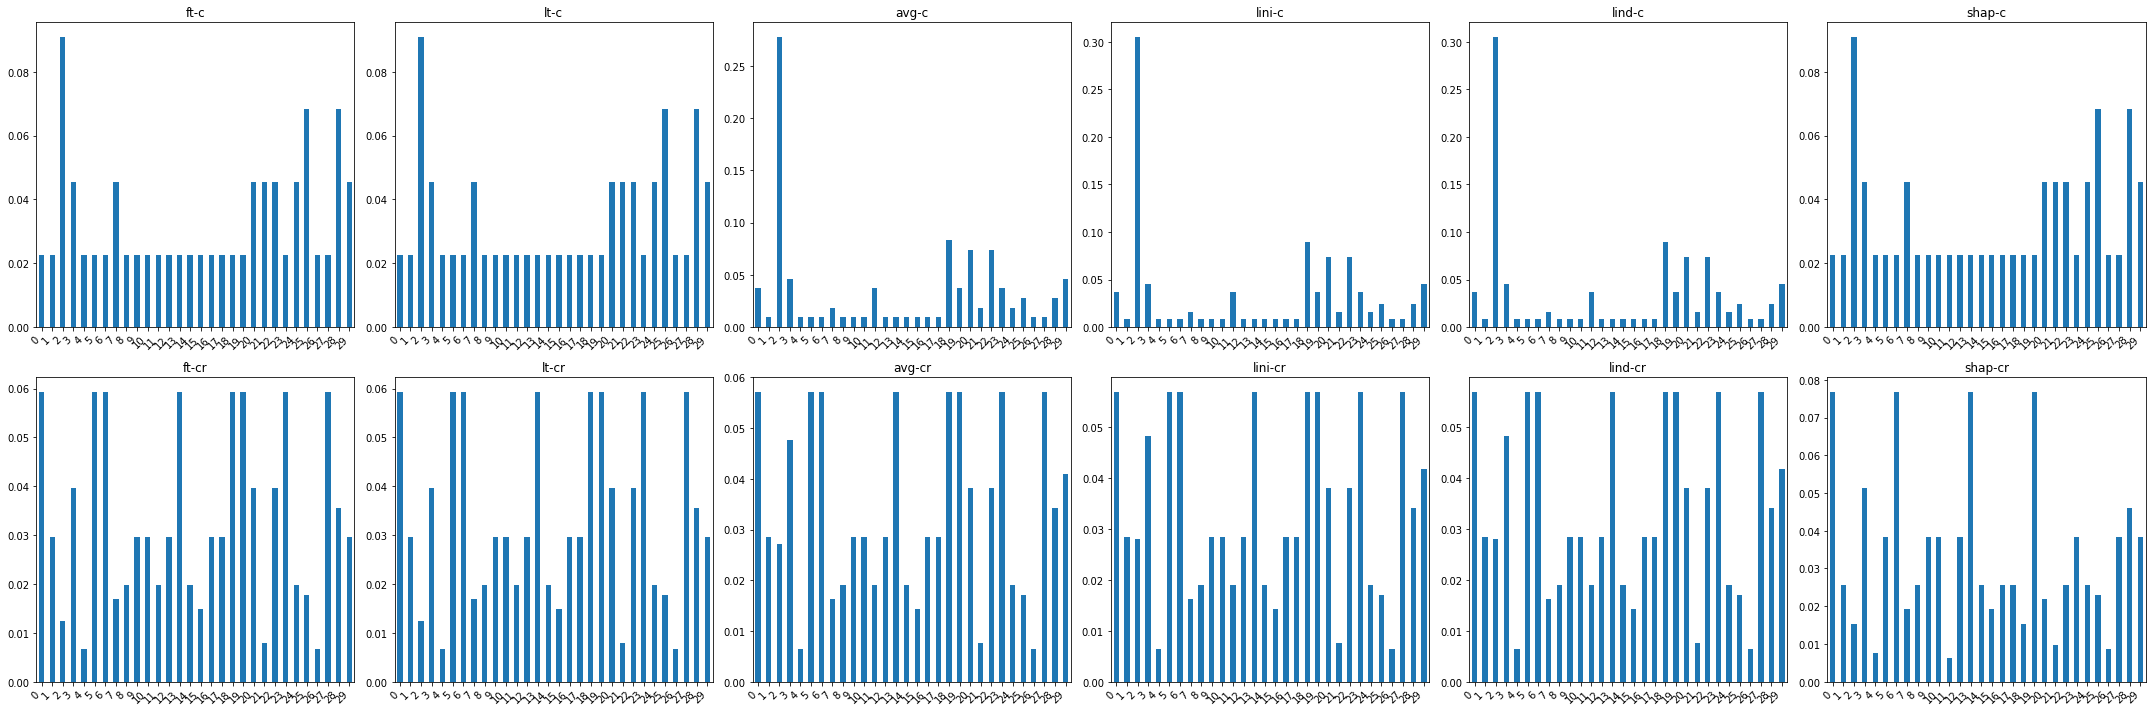

1.epr_$channel.att_norm.png


In [58]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(tgt_modes), len(att_modes), figsize=(len(att_modes)*5, len(tgt_modes)*5))
for j, a in enumerate(att_modes):
    for i, t in enumerate(tgt_modes):
        ax = axs[i][j]
        att_df[f'{a}-{t}'].plot(kind='bar', ax=ax)
        ax.set_title(f'{a}-{t}')
        ax.set_xticklabels(att_df.index if att_df.shape[0]<25 else ax.get_xticks(), rotation = 45, ha='right')
plt.tight_layout()
plt.show()
print(f'{project_id}.{touch_mode}.att_norm.png')